<a href="https://colab.research.google.com/github/jsemer/fibertree-graphs/blob/main/gunrock_scheduling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph scheduling

This notebook is for exploring the scheduling of graph processing algorithms, especially schedules implemented by Gunrock.

**Note:** this notebook is expected to be pushed from Google Colab, so to make sure of a consistent line of development make sure to launch from github (to get the latest version) make updates and push back to github - hopefully before anyone else pushes.

Testing...

In [1]:
# Begin - startup boilerplate code

import pkgutil

if 'fibertree_bootstrap' not in [pkg.name for pkg in pkgutil.iter_modules()]:
  !python3 -m pip  install git+https://github.com/Fibertree-project/fibertree-bootstrap --quiet

# End - startup boilerplate code

from fibertree_bootstrap import *
fibertree_bootstrap(style="tree", animation="movie")

  Preparing metadata (setup.py) ... done
Running bootstrap
The fibertree module is not available. Installing...


interactive(children=(Dropdown(description='style', options=('tree', 'uncompressed', 'tree+uncompressed'), val…

## Create a graph described by an adjacency matrix

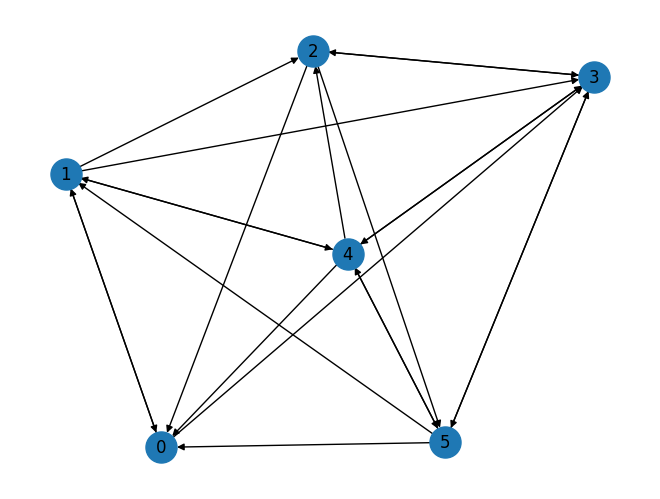

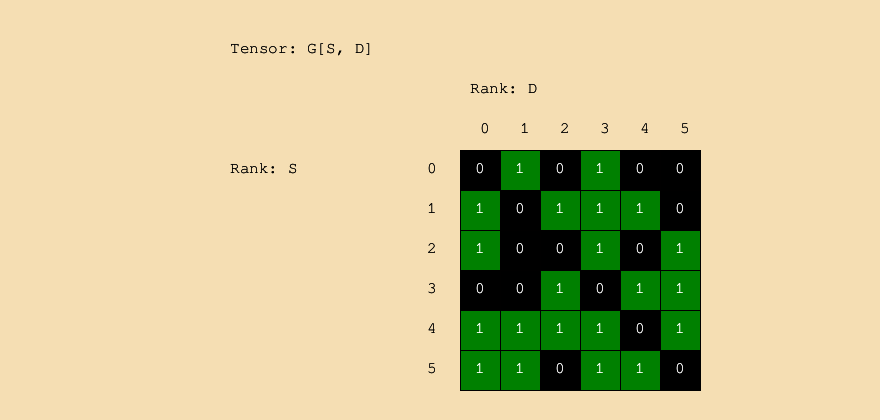

In [2]:
adj_matrix = [ [ 0, 1, 0, 1, 0, 0 ],
              [ 1, 0, 1, 1, 1, 0],
              [ 1, 0, 0, 1, 0, 1],
              [ 0, 0, 1, 0, 1, 1],
              [ 1, 1, 1, 1, 0, 1],
             [ 1, 1, 0, 1, 1, 0]]

g = Tensor.fromUncompressed(rank_ids=["S", "D"],
                            root=adj_matrix,
                            name="G",
                            color="green")

displayGraph(g)
displayTensor(g, style="uncompressed")

## Create a frontier

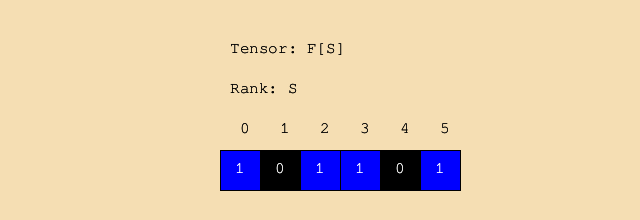

In [3]:
f = Tensor.fromUncompressed(rank_ids=["S"],
                            root=[1, 0, 1, 1, 0, 1],
                            name="F",
                            color="blue")

displayTensor(f, style="uncompressed")

## Perform an "advance"
Essentially equivalent to the Einsum: $Z_d = G_{s,d} \times F_s$

Task 0: s:0, d:1
Task 1: s:0, d:3
Task 2: s:2, d:0
Task 3: s:2, d:3
Task 4: s:2, d:5
Task 5: s:3, d:2
Task 6: s:3, d:4
Task 7: s:3, d:5
Task 8: s:5, d:0
Task 9: s:5, d:1
Task 10: s:5, d:3
Task 11: s:5, d:4
New frontier


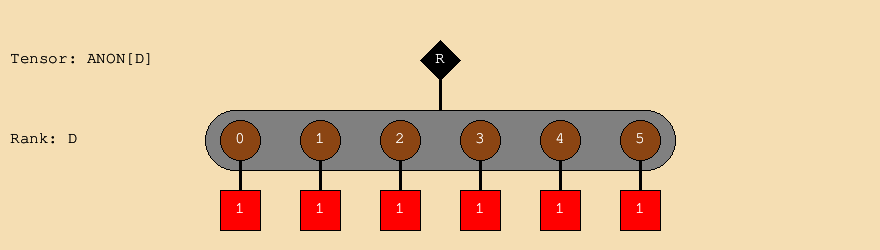

In [4]:
z = Tensor(rank_ids=["D"], shape=f.getShape())

g_s = g.getRoot()
f_s = f.getRoot()
z_d = z.getRoot()

canvas = createCanvas(f, g, z)

task_id = 0
for s, (g_d, f_val) in g_s & f_s:
    for d, (z_ref, g_val) in z_d << g_d:
        print(f"Task {task_id}: s:{s}, d:{d}")
        z_ref <<= 1
        task_id += 1
        canvas.addActivity((s,), (s, d), (d,))

print("New frontier")
displayTensor(z)

print("")
displayCanvas(canvas)

## Create "advance" tasks

Run an "advance" function creating a tensor holding the "task list" for the computation

Task 0: s:0, d:1
Task 1: s:0, d:3
Task 2: s:2, d:0
Task 3: s:2, d:3
Task 4: s:2, d:5
Task 5: s:3, d:2
Task 6: s:3, d:4
Task 7: s:3, d:5
Task 8: s:5, d:0
Task 9: s:5, d:1
Task 10: s:5, d:3
Task 11: s:5, d:4


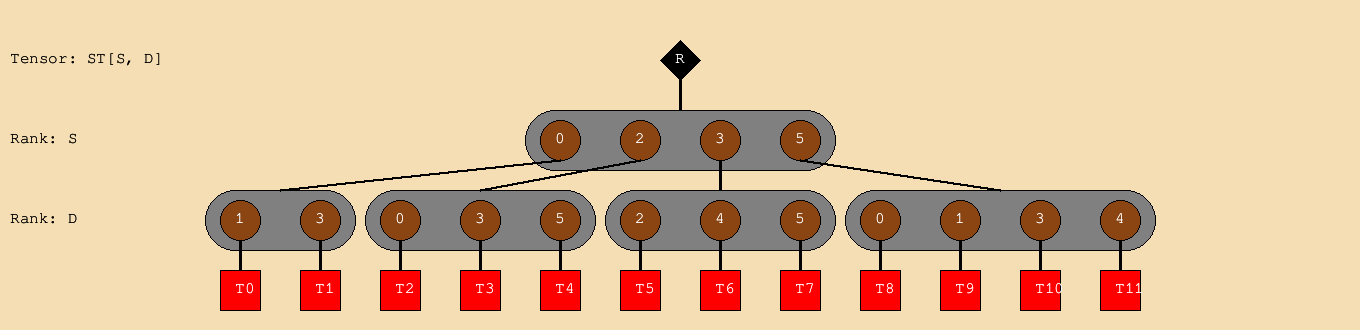

In [5]:
# Visualize the space time aspects
ST = Tensor(name="ST", rank_ids=["S", "D"], shape=g.getShape())

g_s = g.getRoot()
f_s = f.getRoot()
z_s = ST.getRoot()

task_id = 0
for s, (z_d, (g_d, f_val)) in z_s << (g_s & f_s):
    for d, (z_ref, g_val) in z_d << g_d:
        print(f"Task {task_id}: s:{s}, d:{d}")
        z_ref <<= f"T{task_id}"
        task_id += 1

displayTensor(ST)

## Create a schedule

Modify the "task tensor" for form a schedule

This schedule:
- assign every OTHER task to a PE

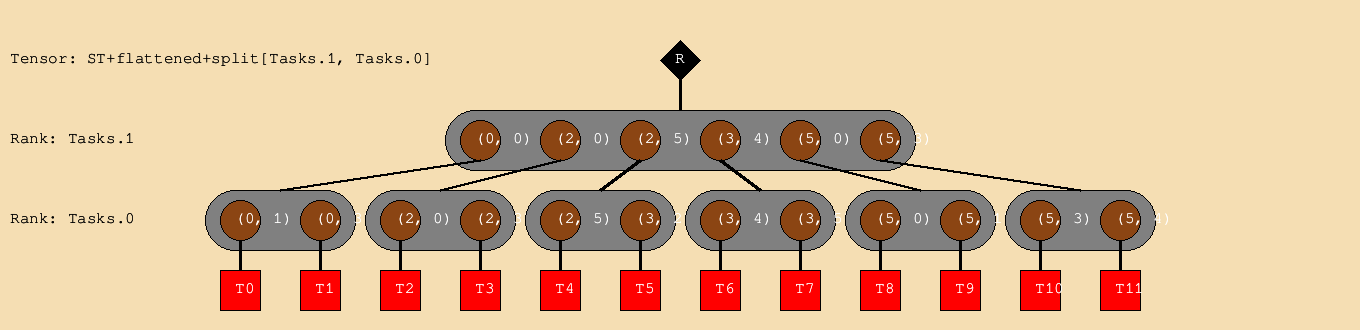

In [6]:
st_flat = ST.flattenRanks()

st_flat.setRankIds(["Tasks"] )   # Hack to allow `split()` to modify the rank name
st_sched = st_flat.splitEqual(2)

# Currently, the next line may crash due to a bug displaying "tuple" coordinates
displayTensor(st_sched)

In [8]:
sched_top = st_sched.getRoot()

g_s = g.getRoot()
f_s = f.getRoot()

w = Tensor(rank_ids=["D"], shape=f.getShape())
w_d = w.getRoot()

canvas = createCanvas(f, g, z, ST)
cycle = 0

for top, task_group in sched_top:
  for pe, ((s, d), _) in enumerate(task_group):
    g_val = g_s.getPayload(s, d)
    f_val = f_s.getPayload(s)
    z_ref = z_d.getPayloadRef(d)
    z_ref <<= g_val * f_val

    canvas.addActivity((s,), (s, d), (d,), (s, d), spacetime=(pe, cycle ) )

  cycle += 1



displayCanvas(canvas)

# Schedule 2
- In this schedule, we parallelize on the $s$ rank (similar to a *thread-mapped* schedule in Gunrock, where each thread is assigned a source vertex.)
- **Question**: How do we account for schedules where the PEs are also assigned "useless" work; that is, pre-interesection work? Our current task list model doesn't account for this and instead generates task post-intersection. But some of the tasks may actually include intersection

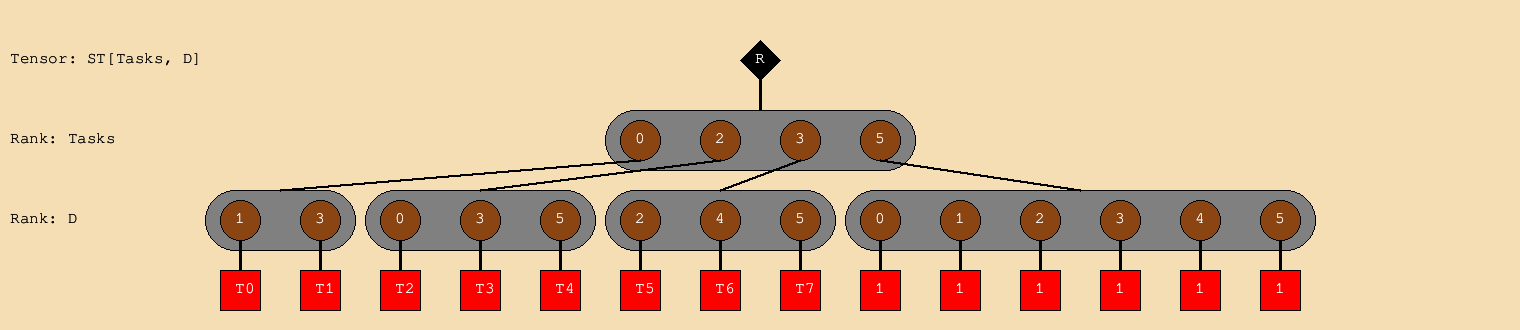

In [10]:
import copy
st_on_s = copy.deepcopy(ST)

st_on_s.setRankIds(["Tasks", "D"] )   # Hack to allow `split()` to modify the rank name
#st_sched = st_flat.splitEqual(2)

# Currently, the next line may crash due to a bug displaying "tuple" coordinates
displayTensor(st_on_s)

In [13]:
sched_top = st_on_s.getRoot()

g_s = g.getRoot()
f_s = f.getRoot()

# What is this being used for?
w = Tensor(rank_ids=["D"], shape=f.getShape())
w_d = w.getRoot()

canvas = createCanvas(f, g, z, ST)
cycle = 0


for pe, (s, task_group) in enumerate(sched_top): #parallel for
  for d, _ in task_group: #sequential for
    g_val = g_s.getPayload(s, d)
    f_val = f_s.getPayload(s)
    z_ref = z_d.getPayloadRef(d)
    z_ref <<= g_val * f_val

    canvas.addActivity((s,), (s, d), (d,), (s, d), spacetime=(pe, cycle ) )

  #if pe % 2:
    cycle += 1



displayCanvas(canvas)

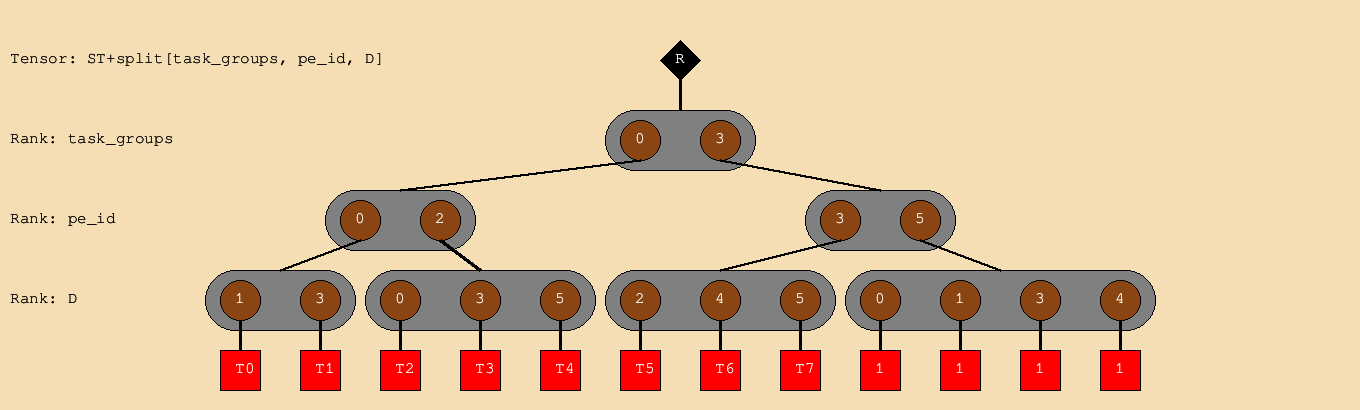

In [16]:
# split s in 2 first
import copy
st_on_s = ST.splitEqual(2)

st_on_s.setRankIds(["task_groups", "pe_id", "D"])   # Hack to allow `split()` to modify the rank name
#st_sched = st_flat.splitEqual(2)

# Currently, the next line may crash due to a bug displaying "tuple" coordinates
displayTensor(st_on_s)

In [22]:
sched_top = st_on_s.getRoot()

g_s = g.getRoot()
f_s = f.getRoot()

# What is this being used for?
w = Tensor(rank_ids=["D"], shape=f.getShape())
w_d = w.getRoot()

canvas = createCanvas(f, g, z, ST, st_on_s)
cycle = 0

# We only have 2 PEs, so we go through the top rank sequentially
for cycles1, (top, task_group) in enumerate(sched_top): #sequential for
  for pe, (s, tasks) in enumerate(task_group): #parallel for, pe can only be 0 or 1
    for cycles0, (d, _) in enumerate(tasks): #sequential for
      g_val = g_s.getPayload(s, d)
      f_val = f_s.getPayload(s)
      z_ref = z_d.getPayloadRef(d)
      z_ref <<= g_val * f_val
      #cycle += 1

      canvas.addActivity((s,), (s, d), (d,), (s, d), (top, s, d), spacetime=(pe, (cycles1, cycles0) ) )

  #if pe % 2:



displayCanvas(canvas)